# 🛫 1. Introdução

## ✈️ FlightOnTime – Previsão de Atraso de Voos

Este notebook constrói um modelo de Machine Learning capaz de prever se um voo será:

- **0 → Pontual**
- **1 → Atrasado**

Com base em variáveis históricas como:

- Companhia aérea  
- Aeroporto de origem e destino  
- Horário programado  
- Distância  
- Atraso na partida  

Etapas do notebook:

1. Importação do dataset (Flight Delays 2015 — US DOT)
2. Análise exploratória (EDA)
3. Criação de variáveis (feature engineering)
4. Treinamento de múltiplos modelos
5. Comparação de desempenho
6. Escolha do melhor modelo
7. Exportação para uso no Back-End

O objetivo final é integrar este modelo a uma **API em Java (Spring Boot)** para o Hackathon ONE.

# 🧩 2. Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")

# 📂 3. Carregando o dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/flights.csv')

Mounted at /content/drive


# 🧩 4. Visão geral do dataset

Antes de criar a variável-alvo e treinar modelos, vamos entender melhor os dados:

- Quantidade de linhas e colunas  
- Primeiras linhas do dataset  
- Tipos de dados de cada coluna  
- Valores ausentes  
- Distribuição básica dos atrasos (`DEPARTURE_DELAY`) e status de cancelamento / desvio  


In [ ]:
# Dimensões do dataset
print("Formato do dataset (linhas, colunas):", df.shape)

Formato do dataset (linhas, colunas): (5819079, 31)


In [ ]:
# Primeiras linhas
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Tipos de dados
df.dtypes

,0
YEAR,int64
MONTH,int64
DAY,int64
DAY_OF_WEEK,int64
AIRLINE,object
FLIGHT_NUMBER,int64
TAIL_NUMBER,object
ORIGIN_AIRPORT,object
DESTINATION_AIRPORT,object
SCHEDULED_DEPARTURE,int64


In [ ]:
# Estatísticas descritivas das colunas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,5819079.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,5819079.0,6.524085,3.405137,1.0,4.0,7.0,9.0,12.0
DAY,5819079.0,15.704594,8.783425,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,5819079.0,3.926941,1.988845,1.0,2.0,4.0,6.0,7.0
FLIGHT_NUMBER,5819079.0,2173.092742,1757.063999,1.0,730.0,1690.0,3230.0,9855.0
SCHEDULED_DEPARTURE,5819079.0,1329.602470,483.751821,1.0,917.0,1325.0,1730.0,2359.0
DEPARTURE_TIME,5732926.0,1335.204439,496.423260,1.0,921.0,1330.0,1740.0,2400.0
DEPARTURE_DELAY,5732926.0,9.370158,37.080942,-82.0,-5.0,-2.0,7.0,1988.0
TAXI_OUT,5730032.0,16.071662,8.895574,1.0,11.0,14.0,19.0,225.0
WHEELS_OFF,5730032.0,1357.170841,498.009356,1.0,935.0,1343.0,1754.0,2400.0


In [ ]:
# Verificando valores ausentes por coluna
df.isna().sum().sort_values(ascending=False)

,0
CANCELLATION_REASON,5729195
LATE_AIRCRAFT_DELAY,4755640
WEATHER_DELAY,4755640
AIRLINE_DELAY,4755640
AIR_SYSTEM_DELAY,4755640
SECURITY_DELAY,4755640
ELAPSED_TIME,105071
AIR_TIME,105071
ARRIVAL_DELAY,105071
WHEELS_ON,92513


In [ ]:
# Quantidade de voos cancelados e desviados
print("Cancelados:", df['CANCELLED'].sum())
print("Desviados :", df['DIVERTED'].sum())

Cancelados: 89884
Desviados : 15187


In [ ]:
# Distribuição de atrasos na saída
df['DEPARTURE_DELAY'].describe()

,ARRIVAL_DELAY
count,5.714008e+06
mean,4.407057e+00
std,3.927130e+01
min,-8.700000e+01
25%,-1.300000e+01
50%,-5.000000e+00
75%,8.000000e+00
max,1.971000e+03


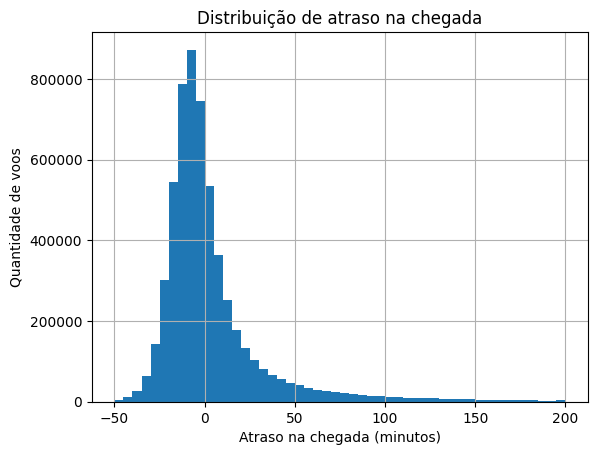

In [ ]:
# Histograma de atraso na chegada (limitando para atrasos razoáveis, ex: entre -50 e 200 minutos)
df[df['DEPARTURE_DELAY'].between(-50, 200)]['DEPARTURE_DELAY'].hist(bins=50)
plt.xlabel("Atraso na partida (minutos)")
plt.ylabel("Quantidade de voos")
plt.title("Distribuição de atraso na partida")
plt.show()

# 🧹 5. Limpeza dos Dados e Feature Engineering

Antes de treinar os modelos, precisamos preparar o dataset.  
Nesta seção, faremos:

- Remoção de colunas que causam *data leakage*  
- Remoção de voos cancelados e desviados  
- Criação da variável-alvo (TARGET)  
- Criação de novas features relevantes (ex.: hora de partida)  
- Codificação de variáveis categóricas  
- Separação entre X (features) e y (alvo)  
- Divisão entre treino e teste  

## ✔️ 5.1 Removendo colunas que causam data leakage

As colunas abaixo representam **motivos do atraso**, registrados somente após o voo acontecer.  
Como queremos prever o atraso **antes do voo**, essas variáveis vazam informação do futuro e devem ser removidas.

Colunas a remover:

- `AIR_SYSTEM_DELAY`
- `SECURITY_DELAY`
- `AIRLINE_DELAY`
- `LATE_AIRCRAFT_DELAY`
- `WEATHER_DELAY`

In [ ]:
colunas_para_remover = [
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
    'CANCELLATION_REASON'
]

df = df.drop(columns=colunas_para_remover)
df.shape

(5819079, 25)

## ❌ 5.2 Removendo voos cancelados e desviados

Para treinar um modelo preditivo confiável, devemos manter apenas voos que **realmente ocorreram**.  
Voos cancelados (`CANCELLED = 1`) ou desviados (`DIVERTED = 1`) não possuem horários reais de chegada, portanto **não servem para prever atraso**.

### 🛑 Por que remover essas linhas?

- Não possuem `ARRIVAL_DELAY` confiável.
- Representam comportamentos especiais (eventos raros) que **poluem o treino**.
- Não fazem parte do objetivo do projeto FlightOnTime, que é prever **se um voo irá atrasar**, assumindo que ele irá decolar.
- Podem distorcer significativamente as métricas.

### ✔️ Regra aplicada:
Manter somente voos onde:

- `CANCELLED == 0`
- `DIVERTED == 0`

In [ ]:
# Removendo voos cancelados e desviados
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

In [ ]:
# Confirmando o novo tamanho do dataset
print("Novo tamanho do dataset:", df.shape)

Novo tamanho do dataset: (5714008, 25)


## 🎯 5.3 Criando a variável-alvo (TARGET)

Nosso objetivo é prever se um voo **irá atrasar**.  
Para isso, precisamos transformar a coluna `ARRIVAL_DELAY` em uma variável binária:

- **0 → Pontual** (voo chegou no horário ou adiantado)
- **1 → Atrasado** (chegou com atraso)

### 📌 Definição usada na indústria
Um voo é considerado **atrasado** quando chega **15 minutos ou mais depois do horário previsto**.

Esse é o padrão utilizado pelo Departamento de Transportes dos EUA (US DOT).

### 🧠 Por que transformar a variável?
Modelos de classificação precisam de um **alvo discreto** (0/1).  
Além disso, trabalhar diretamente com valores de atraso em minutos dificultaria o problema.

### ✔️ Regra aplicada:
Criar a coluna `TARGET`:

- `TARGET = 1` se `ARRIVAL_DELAY >= 15`
- `TARGET = 0` caso contrário

In [ ]:
# Criando a variável-alvo
df['TARGET'] = (df['ARRIVAL_DELAY'] >= 15).astype(int)

In [ ]:
# Visualizando a distribuição da variável-alvo
df['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0,0.813889
1,0.186111


### 5.3.1 📊 Análise da distribuição da variável-alvo (TARGET)

A variável TARGET foi criada para indicar se um voo chegou **pontualmente (0)** ou **atrasado (1)**.

A distribuição encontrada foi:

- **0 — Pontual:** 81,39%
- **1 — Atrasado:** 18,61%

### ⚠️ Observação importante: Dataset desbalanceado

O dataset apresenta um forte desbalanceamento, pois a maioria dos voos é pontual. Isso impacta diretamente o treinamento dos modelos de Machine Learning:

- Acurácia deixa de ser uma métrica confiável
- O modelo pode tender a sempre prever “Pontual”
- Precisamos dar atenção especial à classe minoritária (Atrasado)

### 🛠️ Como trataremos isso na etapa de modelagem?

Durante o treinamento dos modelos, utilizaremos:

- **Class weights (class_weight = 'balanced')** para Logistic Regression e Random Forest  
- **scale_pos_weight** para XGBoost  
- Avaliação com **Recall** e **F1-score** da classe 1 (Atrasado)  

Essas técnicas ajudam o modelo a prestar mais atenção nos casos de atraso, tornando a solução final mais útil.


## ✨ 5.4 Criando novas variáveis (Feature Engineering)

Agora que removemos colunas problemáticas e definimos nossa variável-alvo, vamos criar **novas features** que ajudam o modelo a aprender padrões de atraso.

O objetivo desta etapa é transformar informações brutas do dataset em variáveis mais úteis para o modelo de Machine Learning.

### 🎯 Por que criar novas variáveis?

A maior parte dos atrasos está relacionada a **padrões temporais** e **características do voo**.  
Por isso, vamos derivar novas informações com base nas colunas existentes:

- Horário do voo → manhã, tarde, noite  
- Dia da semana  
- Tipo de aeroporto (origem/destino)  
- Tamanho da distância (curta / média / longa)  

Essas features geralmente aumentam a performance do modelo, pois introduzem relações não explícitas nos dados originais.

### 🕒 5.4.1 Criando a variável `DEPARTURE_HOUR`

A coluna `SCHEDULED_DEPARTURE` indica o horário programado no formato **HHMM**  
Exemplo:  
- 530 → 05h30  
- 1340 → 13h40  

Precisamos extrair apenas a **hora**, pois ela costuma ser um forte indicador de atraso.

#### ✔️ Regra:

DEPARTURE_HOUR = SCHEDULED_DEPARTURE // 100

In [ ]:
df['DEPARTURE_HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).astype(int)

In [ ]:
df['DEPARTURE_HOUR'].head()

,DEPARTURE_HOUR
0,0
1,0
2,0
3,0
4,0


### ✨ 5.4.2 Criando a variável `IS_WEEKEND`

A coluna `DAY_OF_WEEK` do dataset indica o dia da semana do voo:

- **1** → Segunda  
- **2** → Terça  
- **3** → Quarta  
- **4** → Quinta  
- **5** → Sexta  
- **6** → Sábado  
- **7** → Domingo  

Sabemos que **voos operados aos finais de semana** apresentam padrões diferentes de atraso por motivos como:

- menor volume de voos comerciais;  
- operações reduzidas em alguns aeroportos;  
- perfil diferente de passageiros.

Por isso, vamos criar a variável binária **`IS_WEEKEND`**, que indica se o voo ocorreu no sábado ou domingo.

#### ✔️ Regra aplicada

- `IS_WEEKEND = 1` → voo realizado no sábado (6) ou domingo (7)  
- `IS_WEEKEND = 0` → demais dias da semana


In [ ]:
# Criando a variável IS_WEEKEND
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7]).astype(int)

In [ ]:

# Visualizando as primeiras linhas
df[['DAY_OF_WEEK', 'IS_WEEKEND']].head()

,DAY_OF_WEEK,IS_WEEKEND
0,4,0
1,4,0
2,4,0
3,4,0
4,4,0


### ✨ 5.4.3 Criando estatísticas históricas de atraso (features agregadas)

Além das variáveis tradicionais (como horário, companhia e aeroportos), podemos enriquecer o dataset criando **features estatísticas históricas**.  
Essas variáveis ajudam o modelo a capturar padrões reais de atraso que não estão explícitos nos dados originais.

Essas novas features são extremamente valiosas porque incorporam conhecimento do mundo real, como:

- Aeroportos que tradicionalmente atrasam mais;  
- Rotas conhecidas por terem congestionamentos;  
- Destinos com maior variação de tempo de voo;  
- Frequência de voos entre pares de aeroportos.

---

#### 📊 Features criadas nesta etapa

1. **`ORIGIN_DELAY_MEAN`**  
   Média histórica de atraso para cada aeroporto de origem.

2. **`DEST_DELAY_MEAN`**  
   Média histórica de atraso para cada aeroporto de destino.

3. **`ROUTE_DELAY_MEAN`**  
   Média de atraso por rota (`ORIGIN_AIRPORT` → `DESTINATION_AIRPORT`).

4. **`ROUTE_FLIGHT_COUNT`**  
   Quantidade de voos registrados naquela rota (reflete popularidade e carga operacional).

---

#### 💡 Por que isso melhora o modelo?

- Features agregadas são uma das formas mais eficazes de aumentar a performance de modelos supervisionados.  
- Esses atributos introduzem conhecimento que o modelo não conseguiria aprender apenas com colunas brutas.

Assim, damos ao modelo uma visão mais rica e contextual sobre os atrasos.


In [ ]:
# Garantindo que códigos de aeroporto são strings
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)
df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype(str)

# Criando a coluna de rota (origem_destino)
df['ROUTE'] = df['ORIGIN_AIRPORT'] + '_' + df['DESTINATION_AIRPORT']

# Média de atraso por aeroporto de origem
origin_delay_mean = (
    df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY']
      .mean()
      .rename('ORIGIN_DELAY_MEAN')
)

# Média de atraso por aeroporto de destino
dest_delay_mean = (
    df.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY']
      .mean()
      .rename('DEST_DELAY_MEAN')
)

# Média de atraso por rota
route_delay_mean = (
    df.groupby('ROUTE')['ARRIVAL_DELAY']
      .mean()
      .rename('ROUTE_DELAY_MEAN')
)

# Contagem de voos por rota
route_flight_count = (
    df.groupby('ROUTE')['FLIGHT_NUMBER']
      .count()
      .rename('ROUTE_FLIGHT_COUNT')
)

# Integrando ao dataframe principal
df = df.merge(origin_delay_mean, on='ORIGIN_AIRPORT', how='left')
df = df.merge(dest_delay_mean, on='DESTINATION_AIRPORT', how='left')
df = df.merge(route_delay_mean, on='ROUTE', how='left')
df = df.merge(route_flight_count, on='ROUTE', how='left')

In [ ]:
# Visualizando as novas variáveis criadas
df[['ORIGIN_DELAY_MEAN', 'DEST_DELAY_MEAN', 'ROUTE_DELAY_MEAN', 'ROUTE_FLIGHT_COUNT']].head()

,ORIGIN_DELAY_MEAN,DEST_DELAY_MEAN,ROUTE_DELAY_MEAN,ROUTE_FLIGHT_COUNT
0,-0.382286,1.969471,-2.530718,6348
1,5.723421,6.866748,10.051948,77
2,5.750211,2.069756,-2.292104,1811
3,5.723421,5.905049,5.393071,3002
4,2.975567,1.775397,1.923549,6357


## 📉 5.5 Redução do Dataset (Amostragem)

O dataset original possui milhões de registros, o que torna o treinamento de alguns modelos — especialmente o Random Forest — extremamente lento no Google Colab.

Para manter o desempenho do notebook e permitir iteração rápida, vamos utilizar uma **amostragem aleatória de 300.000 linhas**.

Essa quantidade ainda é suficiente para capturar padrões relevantes, mantendo:

- boa representação das rotas  
- distribuição realista de atrasos  
- diversidade de aeroportos  
- variações temporais  

E ao mesmo tempo reduz drasticamente o tempo de treinamento.

> **Observação:** A amostragem é aplicada somente após toda a feature engineering, garantindo que as estatísticas históricas sejam calculadas sobre o dataset completo.

In [ ]:
# Amostragem do dataset para acelerar o treinamento
df_sampled = df.sample(300_000, random_state=42)

# substituímos o df original pelo df_sampled em seguida
df = df_sampled

df.shape

(300000, 33)

# 🧩 6. Separação entre Features (X) e Variável-Alvo (y)

Agora que todas as variáveis importantes foram criadas, precisamos separar o dataset em:

- **X** → conjunto de features (variáveis de entrada usadas pelo modelo)
- **y** → variável-alvo (`TARGET`), que indica se o voo chegou atrasado (1) ou pontual (0)

Essa separação é fundamental para preparar os dados antes da etapa de modelagem.

---

### ✔️ Features utilizadas no modelo

As seguintes variáveis serão usadas como entrada do modelo:

- `AIRLINE`  
- `ORIGIN_AIRPORT`  
- `DESTINATION_AIRPORT`  
- `DISTANCE`  
- `DAY_OF_WEEK`  
- `MONTH`  
- `DEPARTURE_HOUR`  
- `IS_WEEKEND`  
- `ORIGIN_DELAY_MEAN`  
- `DEST_DELAY_MEAN`  
- `ROUTE_DELAY_MEAN`  
- `ROUTE_FLIGHT_COUNT`

Essas features combinam:

- Dados brutos do voo  
- Informações temporais  
- Estatísticas históricas de atraso (extremamente úteis!)  

---

### 🎯 Variável-Alvo

A variável `TARGET` indica:

- `0` → Voo pontual  
- `1` → Voo atrasado  

Ela será usada pelo modelo para aprender os padrões de atraso.

In [ ]:
# Separação entre X (features) e y (alvo)
features = [
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'DISTANCE',
    'DAY_OF_WEEK',
    'MONTH',
    'DEPARTURE_HOUR',
    'IS_WEEKEND',
    'ORIGIN_DELAY_MEAN',
    'DEST_DELAY_MEAN',
    'ROUTE_DELAY_MEAN',
    'ROUTE_FLIGHT_COUNT'
]

target = 'TARGET'

# Criando X e y
X = df[features]
y = df[target]

In [ ]:
X.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DAY_OF_WEEK,MONTH,DEPARTURE_HOUR,IS_WEEKEND,ORIGIN_DELAY_MEAN,DEST_DELAY_MEAN,ROUTE_DELAY_MEAN,ROUTE_FLIGHT_COUNT
3258731,OO,CVG,MKE,318,1,7,16,0,5.895413,3.719609,10.968300,347
4767503,DL,13204,12953,950,5,10,18,0,-0.371863,1.535168,4.459215,331
4367149,WN,13796,14747,672,1,10,11,0,0.981222,-0.463285,1.376147,327
5040207,DL,ATL,SAV,214,2,11,13,0,3.046774,5.241809,3.094720,3125
3989679,OO,GEG,SEA,224,5,9,6,0,2.794386,1.969471,6.014580,3155


In [ ]:
y.head()

,TARGET
3258731,0
4767503,0
4367149,0
5040207,0
3989679,0


# 📚 7. Divisão dos Dados em Treino e Teste

Agora que já separamos o conjunto de features (**X**) e a variável-alvo (**y**), precisamos dividir os dados em:

- **Treino (training set)** → usado para ensinar o modelo a aprender padrões.
- **Teste (test set)** → usado para avaliar o desempenho do modelo em dados nunca vistos.

Essa divisão evita *overfitting*, garantindo que o modelo seja capaz de generalizar para novos voos.

---

## ✔️ Por que usar `stratify=y`?

A variável-alvo (`TARGET`) é desbalanceada:

- maioria dos voos → **pontuais**
- minoria → **atrasados**

Ao usar:

`stratify=y`

Garantimos que tanto o treino quanto o teste terão a mesma proporção de pontuais e atrasados, evitando avaliações distorcidas.

## 🔧 Parâmetros utilizados

`test_size=0.2` → 20% dos dados serão usados para teste

`random_state=42` → reproduzibilidade (permite replicar resultados)

`stratify=y` → mantém proporções da variável-alvo

In [ ]:
# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificando os formatos dos conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 12), (60000, 12), (240000,), (60000,))

# 🛠️ 8. Construção do Pipeline de Pré-processamento

Antes de treinar o modelo, precisamos preparar os dados corretamente.  
Modelos de Machine Learning não conseguem trabalhar diretamente com variáveis categóricas (como `AIRLINE`, `ORIGIN_AIRPORT` ou `DESTINATION_AIRPORT`).  
Por isso, vamos criar um **pipeline de pré-processamento** responsável por transformar essas variáveis.

Usaremos duas técnicas:

---

## 🔷 1. `OneHotEncoder` para variáveis categóricas

Ele converte cada categoria em uma nova coluna binária (0 ou 1).  
Exemplo:

| AIRLINE | → | AIRLINE_AA | AIRLINE_DL | AIRLINE_UA | ... |
|---------|----|--------------|--------------|--------------|------|
| AA      | → | 1 | 0 | 0 | ... |

Isso permite que modelos como **Random Forest**, **Logistic Regression** e outros algoritmos interpretem variáveis não numéricas.

> Usamos `handle_unknown="ignore"` para permitir novas categorias na fase de predição.

---

## 🔷 2. Passagem direta para variáveis numéricas

Features numéricas como:

- `DISTANCE`  
- `DEPARTURE_HOUR`  
- `IS_WEEKEND`  
- `ORIGIN_DELAY_MEAN`  
- `ROUTE_DELAY_MEAN`  

não precisam de transformação, então serão apenas **mantidas** (modo `"passthrough"`).

---

## 🎯 Objetivo do pipeline

Criar um objeto único que:

1. **faz o pré-processamento automaticamente**  
2. **treina o modelo usando os dados já transformados**  
3. **permite salvar tudo junto via `joblib.dump`**, facilitando a integração com o back-end

---

## ✔️ Resultado desta etapa

Após executá-la, teremos:

- `preprocess` → bloco de preparação dos dados  
- Pipeline pronto para ser usado na modelagem (na próxima seção)

In [ ]:
# Definindo quais colunas são categóricas e quais são numéricas
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

numeric_features = [
    'DISTANCE',
    'DAY_OF_WEEK',
    'MONTH',
    'DEPARTURE_HOUR',
    'IS_WEEKEND',
    'ORIGIN_DELAY_MEAN',
    'DEST_DELAY_MEAN',
    'ROUTE_DELAY_MEAN',
    'ROUTE_FLIGHT_COUNT'
]

# Pipeline de pré-processamento
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

preprocess

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['AIRLINE', 'ORIGIN_AIRPORT',
                                  'DESTINATION_AIRPORT']),
                                ('num', 'passthrough',
                                 ['DISTANCE', 'DAY_OF_WEEK', 'MONTH',
                                  'DEPARTURE_HOUR', 'IS_WEEKEND',
                                  'ORIGIN_DELAY_MEAN', 'DEST_DELAY_MEAN',
                                  'ROUTE_DELAY_MEAN', 'ROUTE_FLIGHT_COUNT'])])

# 🤖 9. Treinamento do Modelo Preditivo

Com o pipeline de pré-processamento pronto, podemos avançar para o treinamento dos modelos.  

## 🤖 9.1 Treinamento do Modelo — Logistic Regression

Como primeiro modelo, utilizaremos a **Logistic Regression**, que servirá como **baseline** do projeto.

Este modelo é amplamente utilizado em problemas de classificação binária e apresenta diversas vantagens no nosso contexto:

### 🎯 Por que usar Logistic Regression como baseline?

- Treinamento **rápido**, mesmo com datasets grandes
- Excelente desempenho com dados **One-Hot Encoded**
- Gera **probabilidades bem calibradas**, ideais para consumo via API
- Fácil de interpretar e explicar
- Muito estável em ambientes como o Google Colab

Em projetos reais, é comum validar se modelos mais complexos realmente superam a Logistic Regression antes de adotá-los em produção.

---

### ⚙️ Configuração do modelo

Para lidar com o desbalanceamento da variável-alvo (maioria de voos pontuais), utilizamos:

- `class_weight='balanced'` → ajusta o peso das classes automaticamente
- `max_iter=1000` → garante convergência do algoritmo
- `solver='lbfgs'` → solver eficiente para datasets grandes

---

### 🧱 Montagem do Pipeline Completo

O pipeline integra:

1. **Pré-processamento dos dados** (`preprocess`)
2. **Treinamento do modelo Logistic Regression**

Isso garante que:
- O mesmo pré-processamento seja aplicado em treino e predição
- O modelo possa ser salvo em um único arquivo
- O back-end utilize exatamente o mesmo fluxo de dados

In [ ]:
# Pipeline completo: pré-processamento + Logistic Regression
logreg_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        n_jobs=-1
    ))
])

# Treinamento do modelo
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num', 'passthrough',
                                                  ['DISTANCE', 'DAY_OF_WEEK',
                                                   'MONTH', 'DEPARTURE_HOUR',
                                                   'IS_WEEKEND',
                                                   'ORIGIN_DELAY_MEAN',
                                                   'DEST_DELAY_MEAN',
                                                   'ROUTE_DELAY_MEAN',
                                                   'ROUTE_FLIGHT_COUNT'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

### ✅  9.1.1 Resultado esperado

Após a execução desta célula, teremos:

- Um modelo Logistic Regression totalmente treinado

- Pipeline pronto para:

  - Avaliação de métricas

  - Comparação com outros modelos

  - Exportação via joblib.dump

Na próxima etapa, treinaremos um modelo mais robusto (XGBoost) para comparar desempenho e decidir qual será o modelo final do projeto.

## 🚀 9.2 Treinamento do Modelo — XGBoost

Após treinar um modelo baseline com Logistic Regression, avançamos para um modelo mais poderoso: **XGBoost (Extreme Gradient Boosting)**.

O XGBoost é amplamente utilizado em problemas de **dados tabulares**, sendo conhecido por entregar **alto desempenho preditivo** com excelente eficiência computacional quando bem configurado.

---

### 🎯 Por que usar XGBoost neste projeto?

- Excelente desempenho em **problemas de classificação binária**
- Captura **relações não lineares** entre as variáveis
- Escala melhor que Random Forest em grandes volumes de dados
- Permite controle fino de regularização
- Costuma apresentar **melhor Recall e F1-score** para a classe minoritária (voos atrasados)

Por esses motivos, o XGBoost é um forte candidato a **modelo final** do FlightOnTime.

---

### ⚙️ Configuração do modelo

Para garantir bom desempenho e tempo de treino adequado no Google Colab, utilizamos uma configuração **conservadora e eficiente**, evitando overfitting e longos tempos de execução.

Principais parâmetros utilizados:

- `n_estimators=200` → número de árvores
- `max_depth=6` → controla a complexidade do modelo
- `learning_rate=0.1` → taxa de aprendizado
- `subsample=0.8` → amostragem de linhas (regularização)
- `colsample_bytree=0.8` → amostragem de features (regularização)
- `scale_pos_weight` → corrige o desbalanceamento da variável-alvo
- `tree_method='hist'` → acelera o treinamento em datasets grandes
- `eval_metric='logloss'` → métrica apropriada para classificação binária

---

### ⚖️ Ajuste para desbalanceamento das classes

Como a proporção de voos atrasados é significativamente menor que a de voos pontuais, utilizamos o parâmetro `scale_pos_weight`, calculado como:

```text
(número de exemplos da classe negativa) / (número de exemplos da classe positiva)
```

Isso força o modelo a dar mais importância aos casos de atraso.

---

### 🧱 Montagem do Pipeline Completo

Assim como no modelo anterior, utilizamos um pipeline unificado, integrando:

Pré-processamento (preprocess)

Treinamento do modelo XGBoost

Isso garante consistência entre treino, validação e uso em produção.

In [ ]:
# Calculando scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Pipeline completo: pré-processamento + XGBoost
xgb_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])

# Treinamento do modelo
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num', 'passthrough',
                                                  ['DISTANCE', 'DAY_OF_WEEK',
                                                   'MONTH', 'DEPARTURE_HOUR',
                                                   'IS_WEEKEND',
                                                   'ORIGIN_DELAY_MEAN',
                                                   'DEST_DELAY_MEAN',
                                                   'ROUTE_DELAY_MEAN',
                                                   'ROUTE_FLIGHT_COUNT'])])),
                ('classifier',
                 XGBClass...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

### ✅  9.2.1 Resultado esperado

Após a execução desta célula, teremos:

- Um modelo XGBoost totalmente treinado

- Pipeline pronto para:

  - Avaliação de métricas

  - Comparação direta com a Logistic Regression

  - Seleção do melhor modelo para exportação e uso no back-end

Na próxima seção, realizaremos a avaliação comparativa dos modelos, analisando métricas como Acurácia, Precisão, Recall, F1-score e ROC AUC para decidir qual modelo será adotado no MVP.

## 📊 10. Avaliação e Comparação dos Modelos

Após o treinamento dos modelos, é essencial avaliar seu desempenho para entender sua capacidade de **generalização** — isto é, o quão bem eles conseguem prever atrasos em voos **nunca vistos durante o treinamento**.

Nesta etapa, realizamos uma **avaliação comparativa** entre os dois modelos treinados:

- **Logistic Regression**
- **XGBoost**

O objetivo é identificar qual modelo apresenta o melhor equilíbrio entre desempenho preditivo, estabilidade e viabilidade para uso em produção.

---

### 🎯 Métricas utilizadas

As métricas a seguir ajudam a analisar diferentes aspectos do desempenho dos modelos:

- **Acurácia**: proporção total de previsões corretas  
- **Precisão**: entre os voos previstos como atrasados, quantos realmente atrasaram  
- **Recall (Sensibilidade)**: entre os voos realmente atrasados, quantos o modelo conseguiu identificar  
- **F1-score**: média harmônica entre precisão e recall (especialmente importante para dados desbalanceados)  
- **ROC AUC**: mede a capacidade do modelo de separar as classes

📌 Como o dataset possui muito mais voos pontuais do que atrasados, **Recall, F1-score e ROC AUC** são métricas particularmente relevantes para este problema.

---

### 🧪 Avaliação dos modelos no conjunto de teste

Nesta etapa, utilizamos o conjunto de teste para:

1. Gerar previsões
2. Calcular métricas numéricas
3. Plotar a matriz de confusão
4. Comparar os resultados entre os modelos

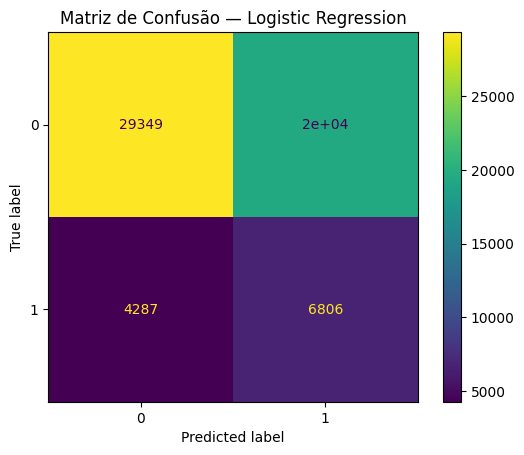

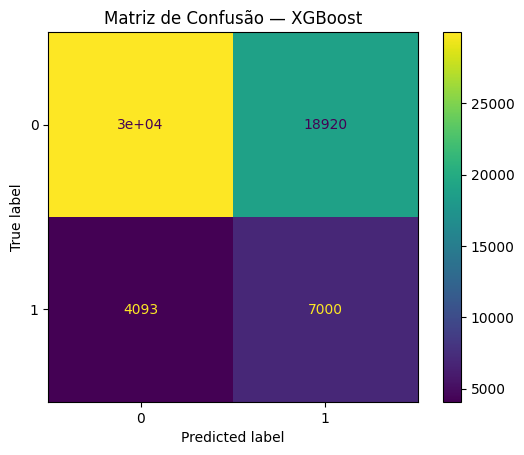

In [ ]:
# Dicionário com os modelos treinados
models = {
    'Logistic Regression': logreg_model,
    'XGBoost': xgb_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Modelo': name,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Matriz de Confusão — {name}')
    plt.show()

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Modelo,Acurácia,Precisão,Recall,F1-score,ROC AUC
0,Logistic Regression,0.602583,0.258155,0.613540,0.363403,0.645611
1,XGBoost,0.616450,0.270062,0.631029,0.378245,0.673991
